In [215]:
import networkx as nx  # es necesario que instales la versión 1.11
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.classes.function import common_neighbors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics


# Primera parte

En la primera parte de esta tarea trabajarás con la red que se forma a partir de las comunicaciones por correo electrónico en una compañía. Cada nodo corresponde a una persona y cada enlace indica que por lo menos se ha enviado un correo entre las personas.

La red también contiene los atributos `Department` y `ManagementSalary`. El atributo `Department` registra el departamento al cual pertenece cada persona y `ManagementSalary` indica si recibe un salario asociado con una posición directiva.


In [216]:
G = nx.read_gpickle('email_prediction.txt')
len(G.nodes())


1005

In [217]:
G.nodes(data=True)[0:10]


[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (7, {'Department': 14, 'ManagementSalary': 0.0}),
 (8, {'Department': 14, 'ManagementSalary': nan}),
 (9, {'Department': 14, 'ManagementSalary': 0.0})]

## Instrucciones [primera parte]

El objetivo de esta primera práctica es que construyas un modelo que prediga el valor de la variable `ManagementSalary`.

1. Ignora los casos en los que no se tiene registrada la etiqueta.
2. Separa el conjunto de datos en subconjuntos de entrenamiento y prueba.
3. Ajusta un modelo a los datos usando alguna técnica de aprendizaje adecuada. Puedes utilizar como predictores métricas que caractericen a los nodos (de centralidad, distancia, conexión, ...).
4. Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


### Eliminamos los casos en los que no se tinee registrada la etiqueta


In [218]:
df = pd.DataFrame(index=G.nodes())
df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
df['ManagementSalary'] = pd.Series(
    nx.get_node_attributes(G, 'ManagementSalary'))


In [219]:
df = df.dropna(subset=['ManagementSalary'])


### Ajusta un modelo a los datos usando alguna técnica de aprendizaje adecuada. Puedes utilizar como predictores métricas que caractericen a los nodos (de centralidad, distancia, conexión, ...).


In [220]:
# Métricas de centralidad
df['degree centrality'] = pd.Series(nx.degree_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))

# metricas de distancia
df['degree'] = pd.Series(nx.degree(G))

# metrica de conexion
df['clustering'] = pd.Series(nx.clustering(G))


In [221]:
df.head()


,Department,ManagementSalary,degree centrality,closeness,betweenness,degree,clustering
0,1,0.0,0.043825,0.421991,0.001124,44,0.276423
3,21,1.0,0.070717,0.441663,0.001654,71,0.384910
4,21,1.0,0.095618,0.462152,0.005547,96,0.318691
6,25,1.0,0.114542,0.475805,0.012387,115,0.155183
7,14,0.0,0.071713,0.420156,0.002818,72,0.287785


In [222]:
len(df)


753

### Separa el conjunto de datos en subconjuntos de entrenamiento y prueba.


In [223]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    'ManagementSalary', axis=1), df['ManagementSalary'], test_size=0.2, random_state=42)


### Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


In [224]:
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [225]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)


AUC: 0.899


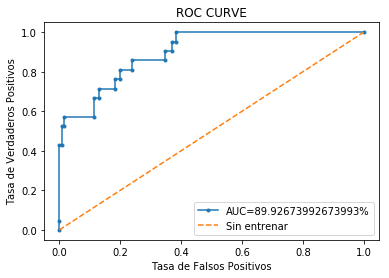

In [226]:
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.', label="AUC="+str(auc*100)+"%")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC CURVE')
plt.legend()
plt.show()


# Segunda parte

En la última parte de esta práctica vas a predecir las futuras conexiones enyte los empleados de la red. La información de la formación de tales conexiones se encuentra en el archivo `future_connections`, cuyo índice es una dupla de nodos que no están conectados actualmente. La columna `Future Connection` indica si en el futuro se establecerá una arista entre ambos nodos (el valor de 1.0 indica una futura conexión).


In [227]:
df = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
df.head(10)


,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


## Instrucciones [segunda parte]

Utiliza la reg `G` (de la primera parte) y `future_connections` para que construyas un modelo que identifique cuáles parejas de nodos en `future_connections` estarán conectados en el futuro.

Para lograrlo, deberás crear una matriz con métricas que caractericen a las aristas de `future_connections` utilizando networkx.

1. Elimina los casos en que la variable de respuesta no se encuentre registrada.
2. Evalúa las características de las parejas de nodos del archivo `future_connections`.
3. Separa los datos en subconjuntos de entrenamiento y prueba.
4. Ajusta un modelo adecuado para predecir la formación de enlaces.
5. Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


### Evalúa las características de las parejas de nodos del archivo `future_connections`.


#### Funciones a utilizar


In [228]:
def get_values(pairs):
    return [i[2] for i in pairs]


def common_neighbors(g):
    comm_neigh = [(e[0], e[1], len(list(nx.common_neighbors(g, e[0], e[1]))))
                  for e in nx.non_edges(g)]
    return get_values(comm_neigh)


def jaccard_coefficient(g):
    jacc = list(nx.jaccard_coefficient(g))
    return get_values(jacc)


def resource_allocation(g):
    res = list(nx.resource_allocation_index(g))
    return get_values(res)


def adamic_adar(g):
    adamic_adar = list(nx.adamic_adar_index(g))
    return get_values(adamic_adar)


def preferential_attachment(g):
    pref = list(nx.preferential_attachment(g))
    return get_values(pref)


#### Evaluando


In [229]:
df.sort_index(inplace=True)
df['common_neighbors'] = common_neighbors(G)
df['jacc_coef'] = jaccard_coefficient(G)
df['res_alloc'] = resource_allocation(G)
df['adamic_adar'] = adamic_adar(G)
df['pref_attach'] = preferential_attachment(G)
df.head(10)


,Future Connection,common_neighbors,jacc_coef,res_alloc,adamic_adar,pref_attach
"(0, 2)",0.0,6,0.045802,0.055340,1.257626,4180
"(0, 3)",0.0,3,0.027273,0.021388,0.605728,3124
"(0, 4)",0.0,3,0.022222,0.021388,0.605728,4224
"(0, 7)",0.0,4,0.036364,0.061668,0.938816,3168
"(0, 8)",0.0,1,0.012821,0.011628,0.224500,1628
"(0, 9)",NaN,2,0.025000,0.041931,0.510499,1760
"(0, 10)",0.0,1,0.011236,0.005882,0.194712,2068
"(0, 11)",0.0,4,0.035088,0.053661,0.899701,3344
"(0, 12)",0.0,4,0.041667,0.065762,0.953236,2552
"(0, 13)",0.0,7,0.032558,0.199248,1.943251,7920


### Elimina los casos en que la variable de respuesta no se encuentre registrada.


In [230]:
df.dropna(subset=['Future Connection'], inplace=True)
df.head(10)


,Future Connection,common_neighbors,jacc_coef,res_alloc,adamic_adar,pref_attach
"(0, 2)",0.0,6,0.045802,0.055340,1.257626,4180
"(0, 3)",0.0,3,0.027273,0.021388,0.605728,3124
"(0, 4)",0.0,3,0.022222,0.021388,0.605728,4224
"(0, 7)",0.0,4,0.036364,0.061668,0.938816,3168
"(0, 8)",0.0,1,0.012821,0.011628,0.224500,1628
"(0, 10)",0.0,1,0.011236,0.005882,0.194712,2068
"(0, 11)",0.0,4,0.035088,0.053661,0.899701,3344
"(0, 12)",0.0,4,0.041667,0.065762,0.953236,2552
"(0, 13)",0.0,7,0.032558,0.199248,1.943251,7920
"(0, 14)",1.0,11,0.099099,0.177760,2.635144,3520


### Separa los datos en subconjuntos de entrenamiento y prueba.


In [231]:
col = list(df.columns)
col.remove('Future Connection')
y = df['Future Connection'].astype(int)
X = df[col]


In [232]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


### Ajusta un modelo adecuado para predecir la formación de enlaces.


In [233]:
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)


In [234]:
print('Accuracy:', model.score(X_test, y_test)*100)


Accuracy: 95.71703495434507


### Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


In [235]:
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred)


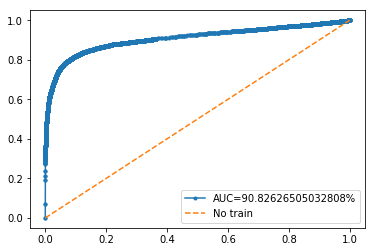

In [236]:
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.', label="AUC="+str(auc*100)+"%")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No train')
plt.legend()
plt.show()
